In [1]:
import pendulum
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy import stats
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree

import shap
import lightgbm as lgb
from pydantic import BaseSettings
from sklearn.metrics import roc_auc_score, recall_score, precision_score

In [2]:
# read the table
df_fraud = pd.read_csv("./Fraud_Data.csv")
df_ip = pd.read_csv("./IpAddress_to_Country.csv")

In [3]:
df_fraud.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [4]:
# 對時間做一些基本的處理

for col in ["signup_time", "purchase_time"]:
    df_fraud[col] = pd.to_datetime(df_fraud[col])
    df_fraud[f"{col}_year"] = df_fraud[col].dt.year
    df_fraud[f"{col}_month"] = df_fraud[col].dt.month
    df_fraud[f"{col}_weekday"] = df_fraud[col].dt.weekday

In [7]:
# print some samples
print(df_fraud.shape)
df_fraud.head()

(151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
# print some samples
print(df_ip.shape)
df_ip.head()

(138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
# 懶人包
plt.ion()
profile = ProfileReport(df_fraud, title="Pandas Profiling Report")
profile

### 懶人包簡易資訊
- 各變數
    - user_id唯一，沒有重複
    - purchase_value 右尾分布
    - source有三類：SEO, Ads, Direct約 2:2:1
    - browser: Chrome, IE, Safari, FireFox, Opera，其中Chrome最多
    - sex: M, F, 男生多一點
    - age: 常態，truncated在18歲
    - class: 屬於umbalanced data (但沒有到很極端)，Fraud約佔10% (比想像中多？)
    - signup & purchase 都是2015年的資料

In [11]:
# ref: https://github.com/ShinminHsu/DS-study-group/blob/shinmin_hsu/01_conversion_rate.ipynb
# Note: update seaborn pkg to latest version, or might occur errors.
def plot_conversion_rate_categorical(df, target, control="conversion"):
    
    custom_params = {"axes.spines.top": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    # calculate the conversion rate and the number of users for each target of interest
    total = df.groupby(target)[control].count().reset_index()
    total[target] = total[target].astype(str)
    group = df[[target, control]].groupby(target).mean().reset_index()
    order_list = group[target]

    fig, g1 = plt.subplots(figsize=(40, 8))
    g2 = g1.twinx()

    # barplot
    sns.countplot(df, x=target, hue=control, order=order_list, ax=g1)
    g1.set_yscale("log")

    # lineplot: to show conversion rate
    g2.plot(group[target].astype(str), group[control], color="dimgrey", marker='o', linestyle='dashed',
         linewidth=2, markersize=8)
    if control == "conversion":
        g2.set(ylim=(0, 0.1))

    # annotation
    for i in range(group.shape[0]):
        x = group.iloc[i][target] - group[target].iloc[0]
        y = group.iloc[i][control]
        label = f"{y*100:.2f}%"

        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color="dimgrey")
        
    # add the number of users for each target of interest to x labels
    labels = [item.get_text() for item in g1.get_xticklabels()]
    labels = [f"{label} \n {total[total[target] == label][control].values[0]:,}" for label in labels]
    g1.set_xticklabels(labels)
    
    fig.text(0.06, 0, 'Note: Numbers under labels are the total number for each label', ha='left', fontsize=20)
    
    plt.title(f"{control} rate by {target}", fontsize=25, pad=40)
    plt.tight_layout()
    plt.show()

Column: signup_time


FixedFormatter should only be used together with FixedLocator


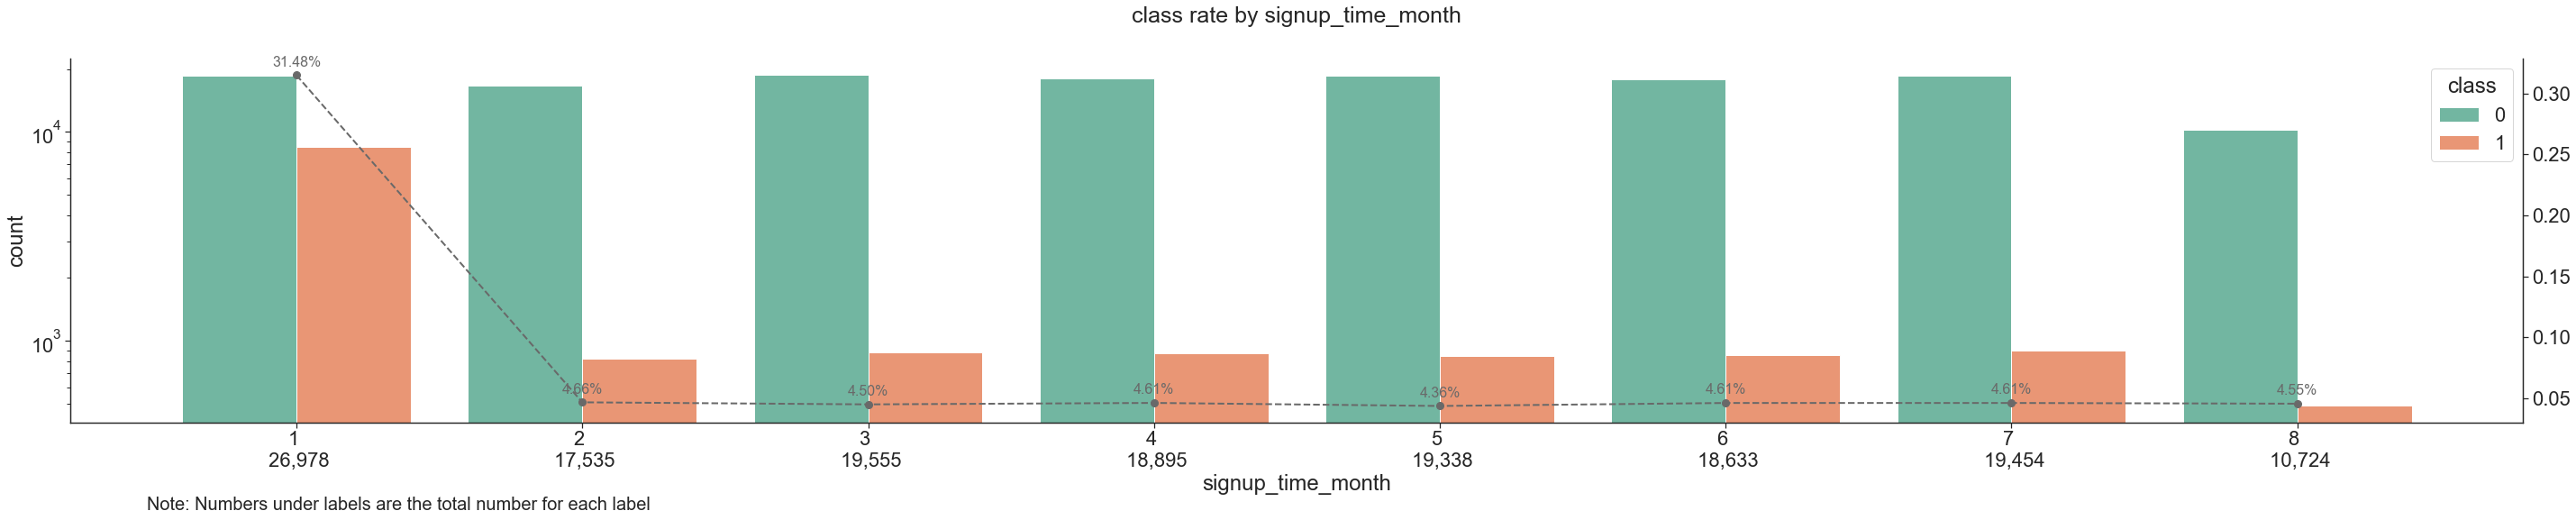

FixedFormatter should only be used together with FixedLocator


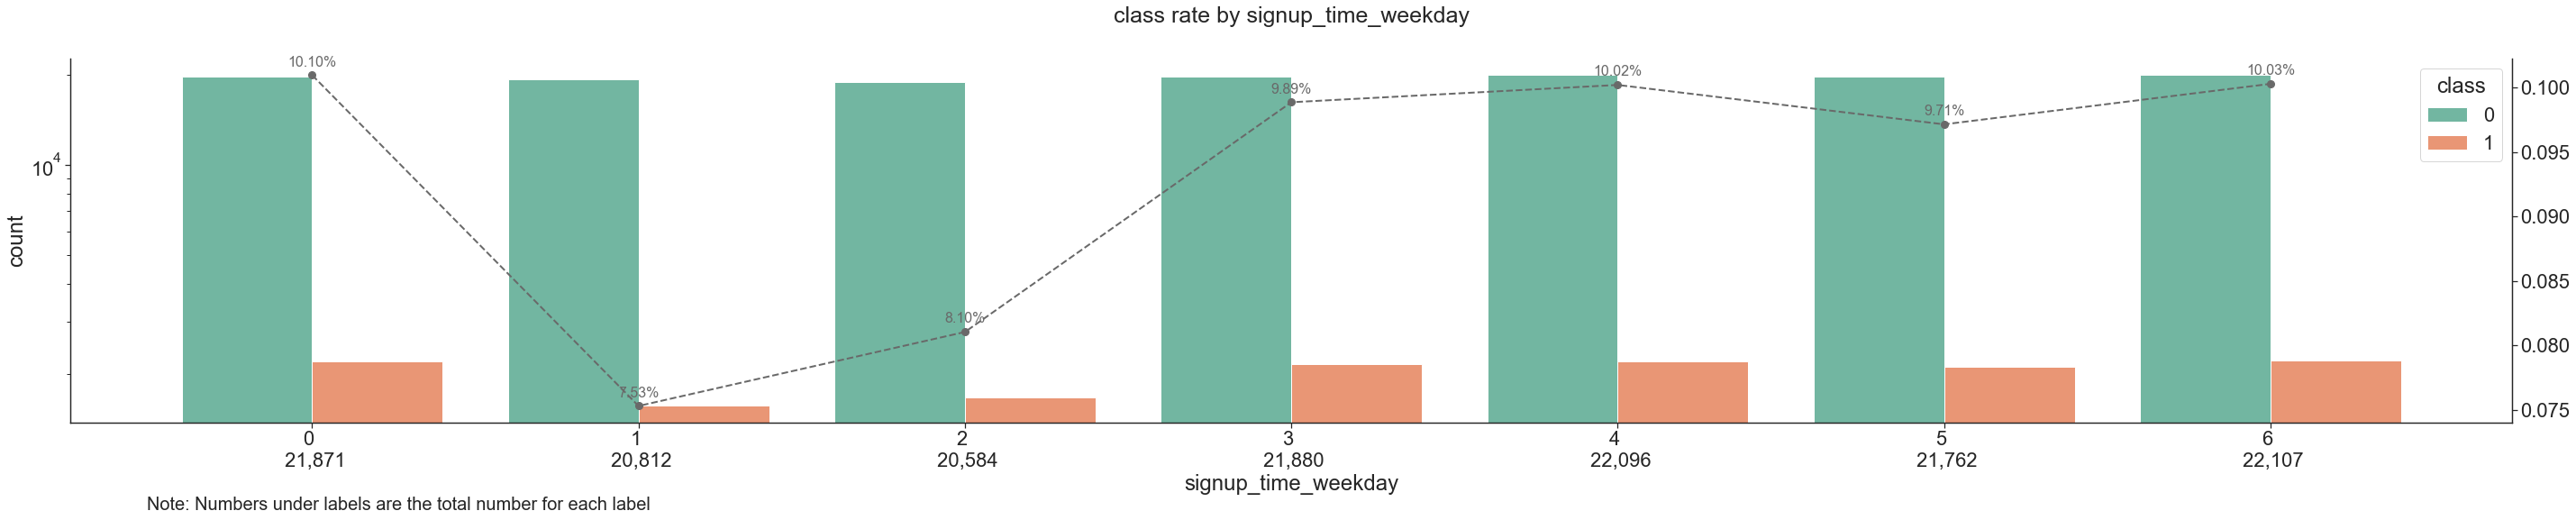

Column: purchase_time


FixedFormatter should only be used together with FixedLocator


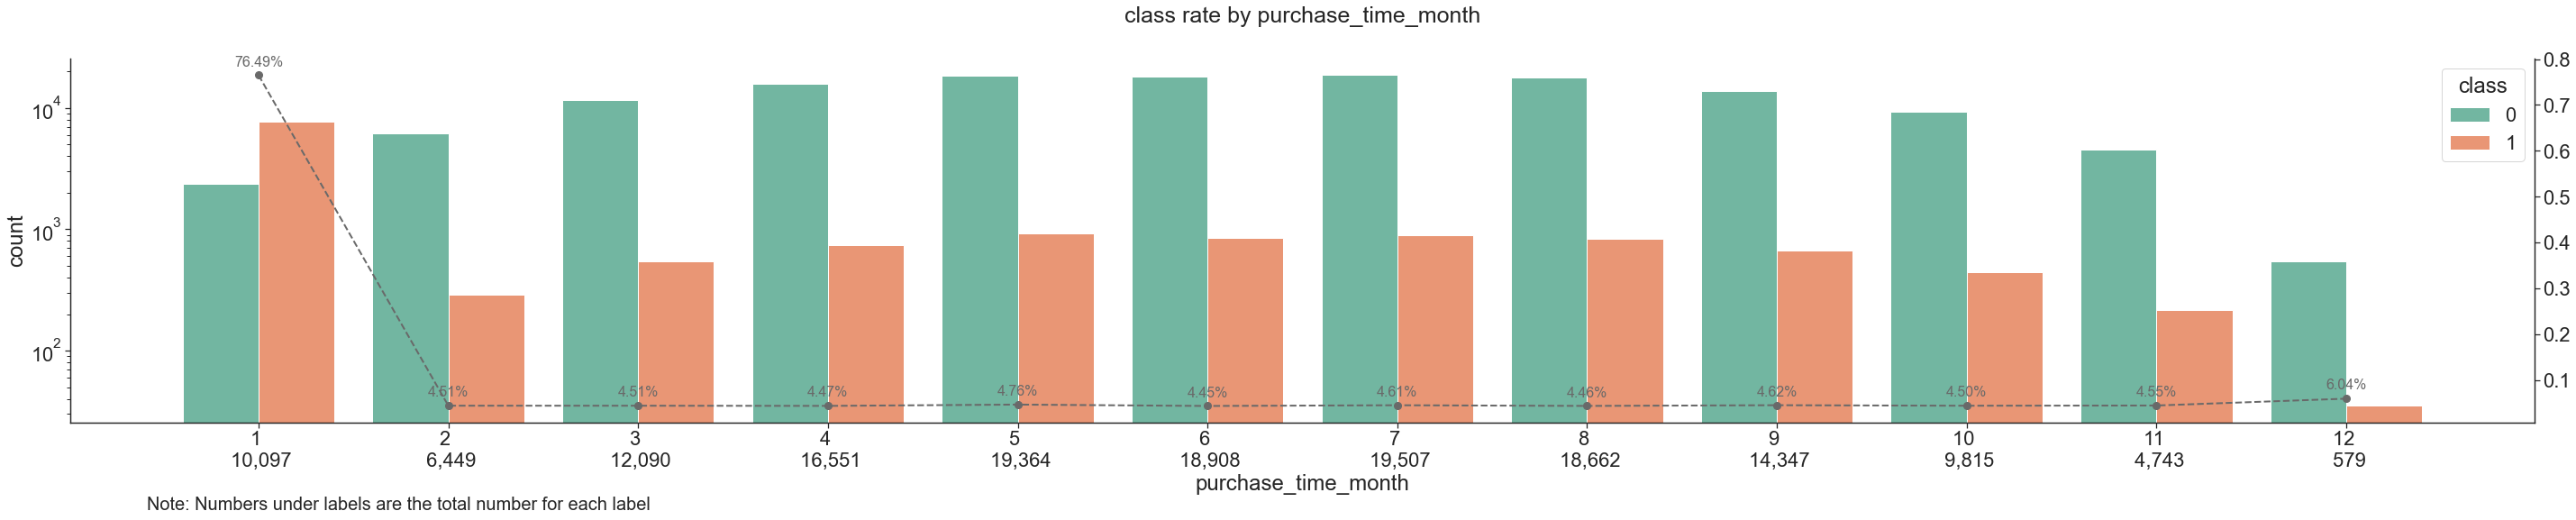

FixedFormatter should only be used together with FixedLocator


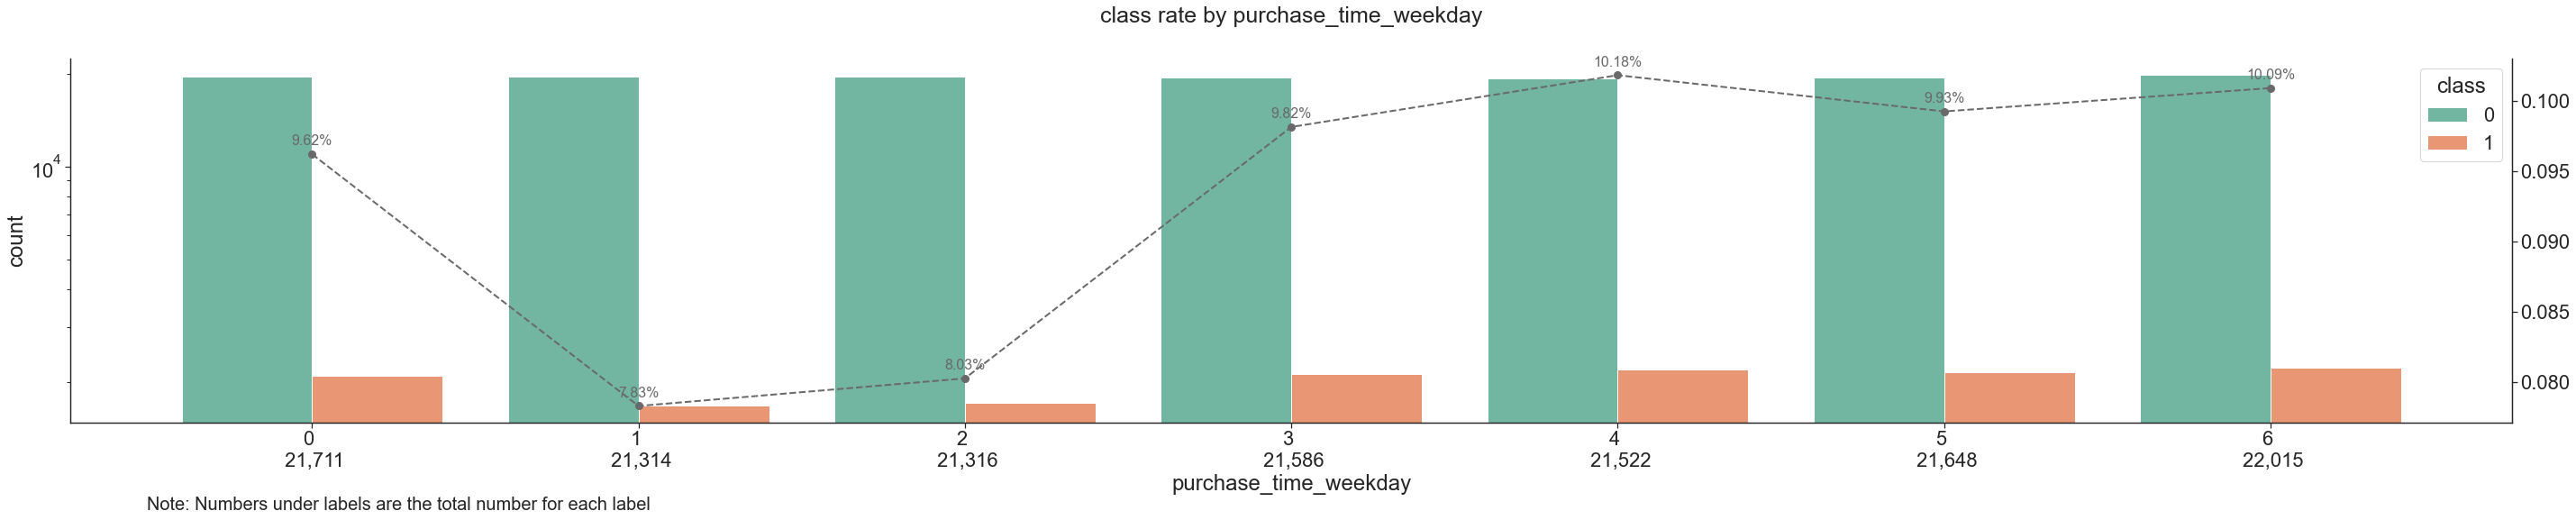

------------------------------------------------


In [23]:
# 觀察時間變數與Fraud的關係
for col in ["signup_time", "purchase_time"]:
    print(f"Column: {col}")
    plot_conversion_rate_categorical(df_fraud, target=f"{col}_month", control="class")
    plot_conversion_rate_categorical(df_fraud, target=f"{col}_weekday", control="class")
print("------------------------------------------------")

- 並非統計一整年的資料？ 
    - 只統計到9月前註冊的人
    - 一月的註冊人數最多 (Fraud也最多)
    - 在一月購買的人，Fraud最多
    - 禮拜一、二 註冊&購物 Fraud的比例最低 (神奇！)
    - 註冊 -> 購買時間差，可能是一個可以納入考慮的特徵

## Q1: For each user, determine her country based on the numeric IP address.

In [42]:
%%time

# baseline
def get_country_from_ip(ip):
#     for lb, up, country in zip(df_ip.lower_bound_ip_address, df_ip.upper_bound_ip_address, df_ip.country):
#         if lb <= ip <= up:
#             return country
    result = df_ip[(df_ip.lower_bound_ip_address <= ip) & (df_ip.upper_bound_ip_address >= ip)]["country"]
    if result.shape[0] == 1:
        return result.iloc[0]
    else:
        return "Unknown"
df_fraud["country"] = df_fraud["ip_address"].apply(lambda x: get_country_from_ip(x))

CPU times: user 2min 47s, sys: 2 s, total: 2min 49s
Wall time: 2min 52s


- 如果用 baseline 的方式找對應國家會耗時非常多時間。
    - 可能在real time inference時造成使用者等待
    - 如何降低運算時間？用什麼資源來取代時間？
    
### Solution
- 定義 > 的 lower_bound (lower_bound_ip_address 是 >=)
- 檢查df_ip 發現
    - ip_diff 最小值為8，且都是8的倍數
        - 因此可以 encode ip的upper bound跟lower bound (縮小距離)
    - 總共有235個國家 (< 256)，在定義type時可以使用int8
- 作法：
    - 對國家做label encoding
    - 定義mapping array，介於lb, ub之間的位置對應到國家index
    - 計算ip_address對應到的位置index再對應回國家
    - 優點：不需要每次找ip時都遍歷一次，只需要計算index再直接去array的位置上對應國家的index即可（優化非常多查詢速度）
    - 缺點：mapping array需要一定的記憶體容量 (int: 3.4G -> int8: 468mb)

In [45]:
%%time
def get_country_from_index(ip, lb_ip, mapping):
    index = (ip - lb_ip) / 8
    if index > mapping.shape[0] or index < 0:
        return "Unknown"
    else:
        return map_dict_r[mapping[int(index)+1]]

df_ip["lower_bound_ip_address_wo"] = df_ip["lower_bound_ip_address"] - 1
df_ip["ip_diff"] = df_ip["upper_bound_ip_address"] - df_ip["lower_bound_ip_address_wo"]
lb_ip = df_ip["lower_bound_ip_address_wo"].min()
df_ip["ip_index_ub"] = ((df_ip["upper_bound_ip_address"] - lb_ip) / 8).astype(int)
df_ip["ip_index_lb"] = ((df_ip["lower_bound_ip_address_wo"] - lb_ip) / 8).astype(int)

lb = pd.Categorical(df_ip["country"])
map_dict = {c: i for i, c in enumerate(lb.categories)}
map_dict_r = {i: c for i, c in enumerate(lb.categories)}
map_dict.update({"Unknown": -1})
map_dict_r.update({-1: "Unknown"})

mapping = np.full((int(df_ip.ip_index_ub.max())+10), -1, dtype=int)
for lb, ub, country in zip(df_ip.ip_index_lb, df_ip.ip_index_ub, df_ip.country):
    mapping[lb+1:ub+1] = map_dict[country]
df_fraud["country2"] = df_fraud["ip_address"].apply(lambda x: get_country_from_index(x, lb_ip, mapping))

CPU times: user 2.32 s, sys: 2.66 s, total: 4.98 s
Wall time: 5.96 s


In [46]:
%%time
def get_country_from_index(ip, lb_ip, mapping):
    index = (ip - lb_ip) / 8
    if index > mapping.shape[0] or index < 0:
        return "Unknown"
    else:
        return map_dict_r[mapping[int(index)+1]]

df_ip["lower_bound_ip_address_wo"] = df_ip["lower_bound_ip_address"] - 1
df_ip["ip_diff"] = df_ip["upper_bound_ip_address"] - df_ip["lower_bound_ip_address_wo"]
lb_ip = df_ip["lower_bound_ip_address_wo"].min()
df_ip["ip_index_ub"] = ((df_ip["upper_bound_ip_address"] - lb_ip) / 8).astype(int)
df_ip["ip_index_lb"] = ((df_ip["lower_bound_ip_address_wo"] - lb_ip) / 8).astype(int)

lb = pd.Categorical(df_ip["country"])
map_dict = {c: i-128 for i, c in enumerate(lb.categories)}
map_dict_r = {i-128: c for i, c in enumerate(lb.categories)}
map_dict.update({"Unknown": 127})
map_dict_r.update({127: "Unknown"})

mapping = np.full((int(df_ip.ip_index_ub.max())+10), 127, dtype=np.int8)
for lb, ub, country in zip(df_ip.ip_index_lb, df_ip.ip_index_ub, df_ip.country):
    mapping[lb+1:ub+1] = map_dict[country]
df_fraud["country3"] = df_fraud["ip_address"].apply(lambda x: get_country_from_index(x, lb_ip, mapping))

CPU times: user 850 ms, sys: 377 ms, total: 1.23 s
Wall time: 1.23 s


In [48]:
# check result
(df_fraud["country"] == df_fraud["country3"]).mean()

1.0

In [49]:
# save to pickle file
import pickle
with open("ip_mapping.pkl", "wb") as file:
    pickle.dump((mapping, map_dict, map_dict_r), file)

In [52]:
%%time
# load from pickle
with open("ip_mapping.pkl", "rb") as file:
    mapping, map_dict, map_dict_r = pickle.load(file)

CPU times: user 1.58 ms, sys: 385 ms, total: 387 ms
Wall time: 424 ms


## Q2: Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

In [211]:
# more feature engineering
df_fraud["diff_purchase_signup_days"] = (df_fraud["purchase_time"] - df_fraud["signup_time"]).dt.days


# frequency encoding

# device_id frequency
device_map_dict = dict(df_fraud.device_id.value_counts())
df_fraud["device_id_freq"] = df_fraud.device_id.map(device_map_dict)

# ip address frequency
ip_address_map_dict = dict(df_fraud.ip_address.value_counts())
df_fraud["ip_address_frep"] = df_fraud.ip_address.map(ip_address_map_dict)

In [212]:
# 建立一個confusion matrix plot
# 用於視覺化模型結果
def metrics_plot(dataset, estimator=None, prediction=None):
    # Plot non-normalized confusion matrix
    assert dataset is not None
    
    X_train, y_train, X_test, y_test = dataset
    titles_options = [
        ["Confusion matrix, Training Data", [X_train, y_train],None],
        ["Confusion matrix, Testing Data", [X_test, y_test], None],
    #     ("Normalized confusion matrix", "true"),
    ]

    if estimator:
        for title, d, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(
                estimator,
                d[0],
                d[1],
                display_labels=["Not Fraud", "Fraud"],
                cmap=plt.cm.Blues,
                normalize=normalize,
            )
            disp.ax_.set_title(title)
        #     print(title)
        #     print(disp.confusion_matrix)
        print(classification_report(y_test, estimator.predict(X_test), target_names=["Not Fraud", "Fraud"], digits=3))
    else:
        if not estimator:
            for i, d in enumerate(titles_options):
                titles_options[i][1][0] = prediction[i]
            for title, d, normalize in titles_options:
                disp = ConfusionMatrixDisplay.from_predictions(
                    d[1],
                    d[0],
                    display_labels=["Not Fraud", "Fraud"],
                    cmap=plt.cm.Blues,
                    normalize=normalize,
                )
                disp.ax_.set_title(title)
            #     print(title)
            #     print(disp.confusion_matrix)
            print(classification_report(y_test, titles_options[1][1][0], target_names=["Not Fraud", "Fraud"], digits=3))
        else:
            raise
    return

In [213]:
# data split (using date)
# Re-design the dataset
df_le = df_fraud.copy(deep=True)
cat_features = ["source", "browser", "sex", "country"]

for idx, f in enumerate(cat_features):
    print(f"Label Encoding for: {f}")
    lb = pd.Categorical(df_fraud[f])
    map_dict = {i: c for i, c in enumerate(lb.categories)}
    print(f"Mapping: {map_dict}")
    df_le[f"{f}_lb"] = lb.codes
    cat_features[idx] = f"{f}_lb"

# delete original columns
del df_le["country"], df_le["source"], df_le["sex"], df_le["browser"]

# define features & target
features = ['purchase_value', 'age', 'signup_time_weekday', 'purchase_time_weekday',
           'diff_purchase_signup_days', 'device_id_freq', 'ip_address_frep', 'source_lb',
           'browser_lb', 'sex_lb', 'country_lb']
target = ["class"]

# train : test = 8:2
X_train, X_test, y_train, y_test = train_test_split(df_le[features], df_le[target], test_size=0.2, random_state=42)

# split_date = "2015-08-01"
# X_train, y_train = df_le[df_le["purchase_time"] < pd.to_datetime(split_date)][features], df_le[df_le["purchase_time"] < pd.to_datetime(split_date)][target]
# X_test, y_test = df_le[df_le["purchase_time"] >= pd.to_datetime(split_date)][features], df_le[df_le["purchase_time"] >= pd.to_datetime(split_date)][target]
cat_idxs = [list(X_train.columns).index(f) for f in cat_features]
cat_dims = [X_train[f].value_counts().index.shape[0]for f in cat_features]

Label Encoding for: source
Mapping: {0: 'Ads', 1: 'Direct', 2: 'SEO'}
Label Encoding for: browser
Mapping: {0: 'Chrome', 1: 'FireFox', 2: 'IE', 3: 'Opera', 4: 'Safari'}
Label Encoding for: sex
Mapping: {0: 'F', 1: 'M'}
Label Encoding for: country
Mapping: {0: 'Afghanistan', 1: 'Albania', 2: 'Algeria', 3: 'Angola', 4: 'Antigua and Barbuda', 5: 'Argentina', 6: 'Armenia', 7: 'Australia', 8: 'Austria', 9: 'Azerbaijan', 10: 'Bahamas', 11: 'Bahrain', 12: 'Bangladesh', 13: 'Barbados', 14: 'Belarus', 15: 'Belgium', 16: 'Belize', 17: 'Benin', 18: 'Bermuda', 19: 'Bhutan', 20: 'Bolivia', 21: 'Bonaire; Sint Eustatius; Saba', 22: 'Bosnia and Herzegowina', 23: 'Botswana', 24: 'Brazil', 25: 'British Indian Ocean Territory', 26: 'Brunei Darussalam', 27: 'Bulgaria', 28: 'Burkina Faso', 29: 'Burundi', 30: 'Cambodia', 31: 'Cameroon', 32: 'Canada', 33: 'Cape Verde', 34: 'Cayman Islands', 35: 'Chile', 36: 'China', 37: 'Colombia', 38: 'Congo', 39: 'Congo The Democratic Republic of The', 40: 'Costa Rica', 41

# Light GBM

In [216]:
class ModelConfigsSettings(BaseSettings):
    """Config for prediction models' parameters."""
    # specify your configurations as a dict
    lgb_params: dict = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 63,
        'max_depth': 8,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }
    early_stopping_rounds: int = 100
    num_boost_round: int = 1000
model_config = ModelConfigsSettings()
model_config.lgb_params["categorical_features"] = cat_idxs

In [217]:
# create lgb dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(
    X_test, y_test, reference=lgb_train)
evals_result = {}

gbm_or = lgb.train(model_config.lgb_params,
                                lgb_train,
                                num_boost_round=model_config.num_boost_round,
                                valid_sets=lgb_eval
                               , early_stopping_rounds=model_config.early_stopping_rounds,
                )

[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Info] Number of positive: 11301, number of negative: 109588
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 120889, number of used features: 11
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093482 -> initscore=-2.271837
[LightGBM] [Info] Start training from score -2.271837
[1]	valid_0's binary_logloss: 0.260777
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.240193
[3]	valid_0's binary_logloss: 0.225987
[4]	valid_0's binary_logloss: 0.216869
[5]	valid_0's binary_logloss: 0.20795

              precision    recall  f1-score   support

   Not Fraud      0.954     1.000     0.976     27373
       Fraud      0.994     0.540     0.700      2850

    accuracy                          0.956     30223
   macro avg      0.974     0.770     0.838     30223
weighted avg      0.958     0.956     0.950     30223



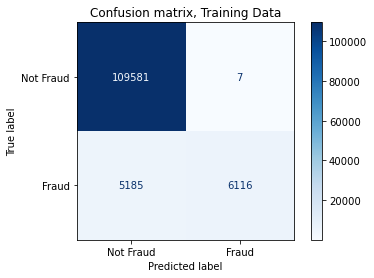

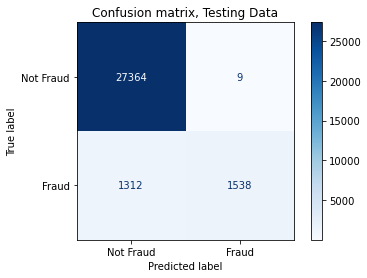

In [218]:
# y_pred_train = np.round(gbm_or.predict(X_train), decimals=0)
# y_pred_test = np.round(gbm_or.predict(X_test), decimals=0)

threshold = 0.5
y_pred_train = (gbm_or.predict(X_train) > threshold).astype(int)
y_pred_test = (gbm_or.predict(X_test) > threshold).astype(int)

metrics_plot(dataset=(X_train, y_train, X_test, y_test), prediction=(y_pred_train, y_pred_test))

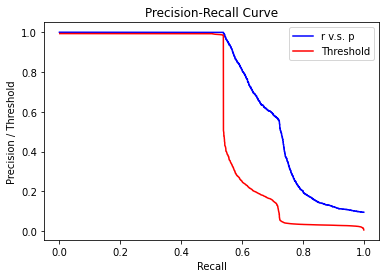

                  0
count  30223.000000
mean       0.093804
std        0.214788
min        0.005476
25%        0.028159
50%        0.031322
75%        0.036254
max        0.993230


In [219]:
# pr curve ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
from sklearn.metrics import precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, gbm_or.predict(X_test), pos_label=1)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue', label= "r v.s. p")
ax.plot(recall[:-1], thresholds, color='red', label="Threshold")


#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision / Threshold')
ax.set_xlabel('Recall')
ax.legend()

#display plot
plt.show()

print(pd.DataFrame(gbm_or.predict(X_test)).describe())

### Dicussion
- 隨機切是否合適？ 我認為不合適
    - 因為他是屬於有時序性的資料，應該要以時間做切割 (以特定時間點切訓練、測試資料，避免data leak的情況發生)
    - 更能符合未來要inference的形式，以當下+過去的資訊預測未來
- 若以時間點做切割，可能會遇到分布不同，處理的方式：
    - adversarial validation (有切train/valid/test時使用)，找出training data裡像testing data的樣本當做validation data
    - 使用不會使模型過於複雜或能夠解釋其預測結果的特徵來進行預測 (domain knowhow)
    - 做ensemble 讓模型更robust
- 但在這次作業中遇到一個問題 (train不起來，感覺需要思考一下作法)

### 先假設隨機分配合適的狀況進行以下討論
- 模型得到的分數
    - Acc: 95.6%
    - Precision: 99.4%
    - Recall: 54.0%
    - F1 score: 70.0%
- Precsion & Recall 代表的意義
    - Precsion: 避免誤殺 (模型預測出的Fraud，是否真的為Fraud)
    - Recall: 漏網之魚 (模型是否真的抓出所有的Fraud)
    - 從結果來看，可以發現模型在threshold=0.5時，誤殺的比例極低 (Precision很高)
- 從pr curve上，可以發現一些事
    - precision & recall 透過threshold的調整會造成trade-off
    - 預測值最大值為0.993230 (模型特定樣本判別Fraud很容易, 雖然Precision很高，但隨著Threshold往下Precision急劇下降，就會讓Fraud全部跑到Not Fraud)
    - 將Threshold往下調，可以提升Recall的performance (反之precsion掉很快)。

## Q3: Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

- 透過Feature importance (gain & shap)找出重要特徵
    - Global interpretability: 
        - lgb feature importance: 每個變數的貢獻程度 (變數當成分割點的純度)
        - shap beeswarm: 觀察變數與Shap value的關係 (變數大小影響預測值)
    - Instance-wise interpretability:
        - shap waterfall: 觀察每個樣本的變數值對Shap的貢獻度
        - TabNet: 模型在NN的每個階段認為哪個特徵是重要的 (Ref: https://github.com/ShinminHsu/DS-study-group/blob/tony_gu/Conversion_Rate/hw1-Conversion_Rate_Modeling.ipynb)
        - Tree-based model: 畫出一棵樹解釋樣本走到哪個節點 (RF: 投票, Gbdt: Fit殘差)
        - gbdt 可以用第一棵樹解釋
- 從beeswarm & lgb feature importance可以看出
    - 主要特徵ip_address_freq、device_id_freq、diff_purchase_signup_days
    - 部分ip_address_freq多的人，影響Shap為正向 (同ip使用頻率越高，風險越高)
    - 部分device_id_freq多的人，影響Shap為正向 (同裝置使用頻率越高，風險越高)
    - diff_purchase_signup_days越短的人，影響Shap為正向 (註冊與購買時間越短，風險越高)

Plotting feature importances...


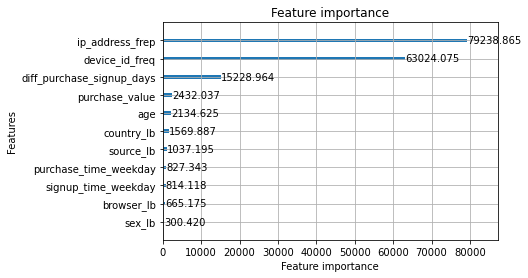

In [220]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm_or, importance_type="gain")
plt.show()

<AxesSubplot:>

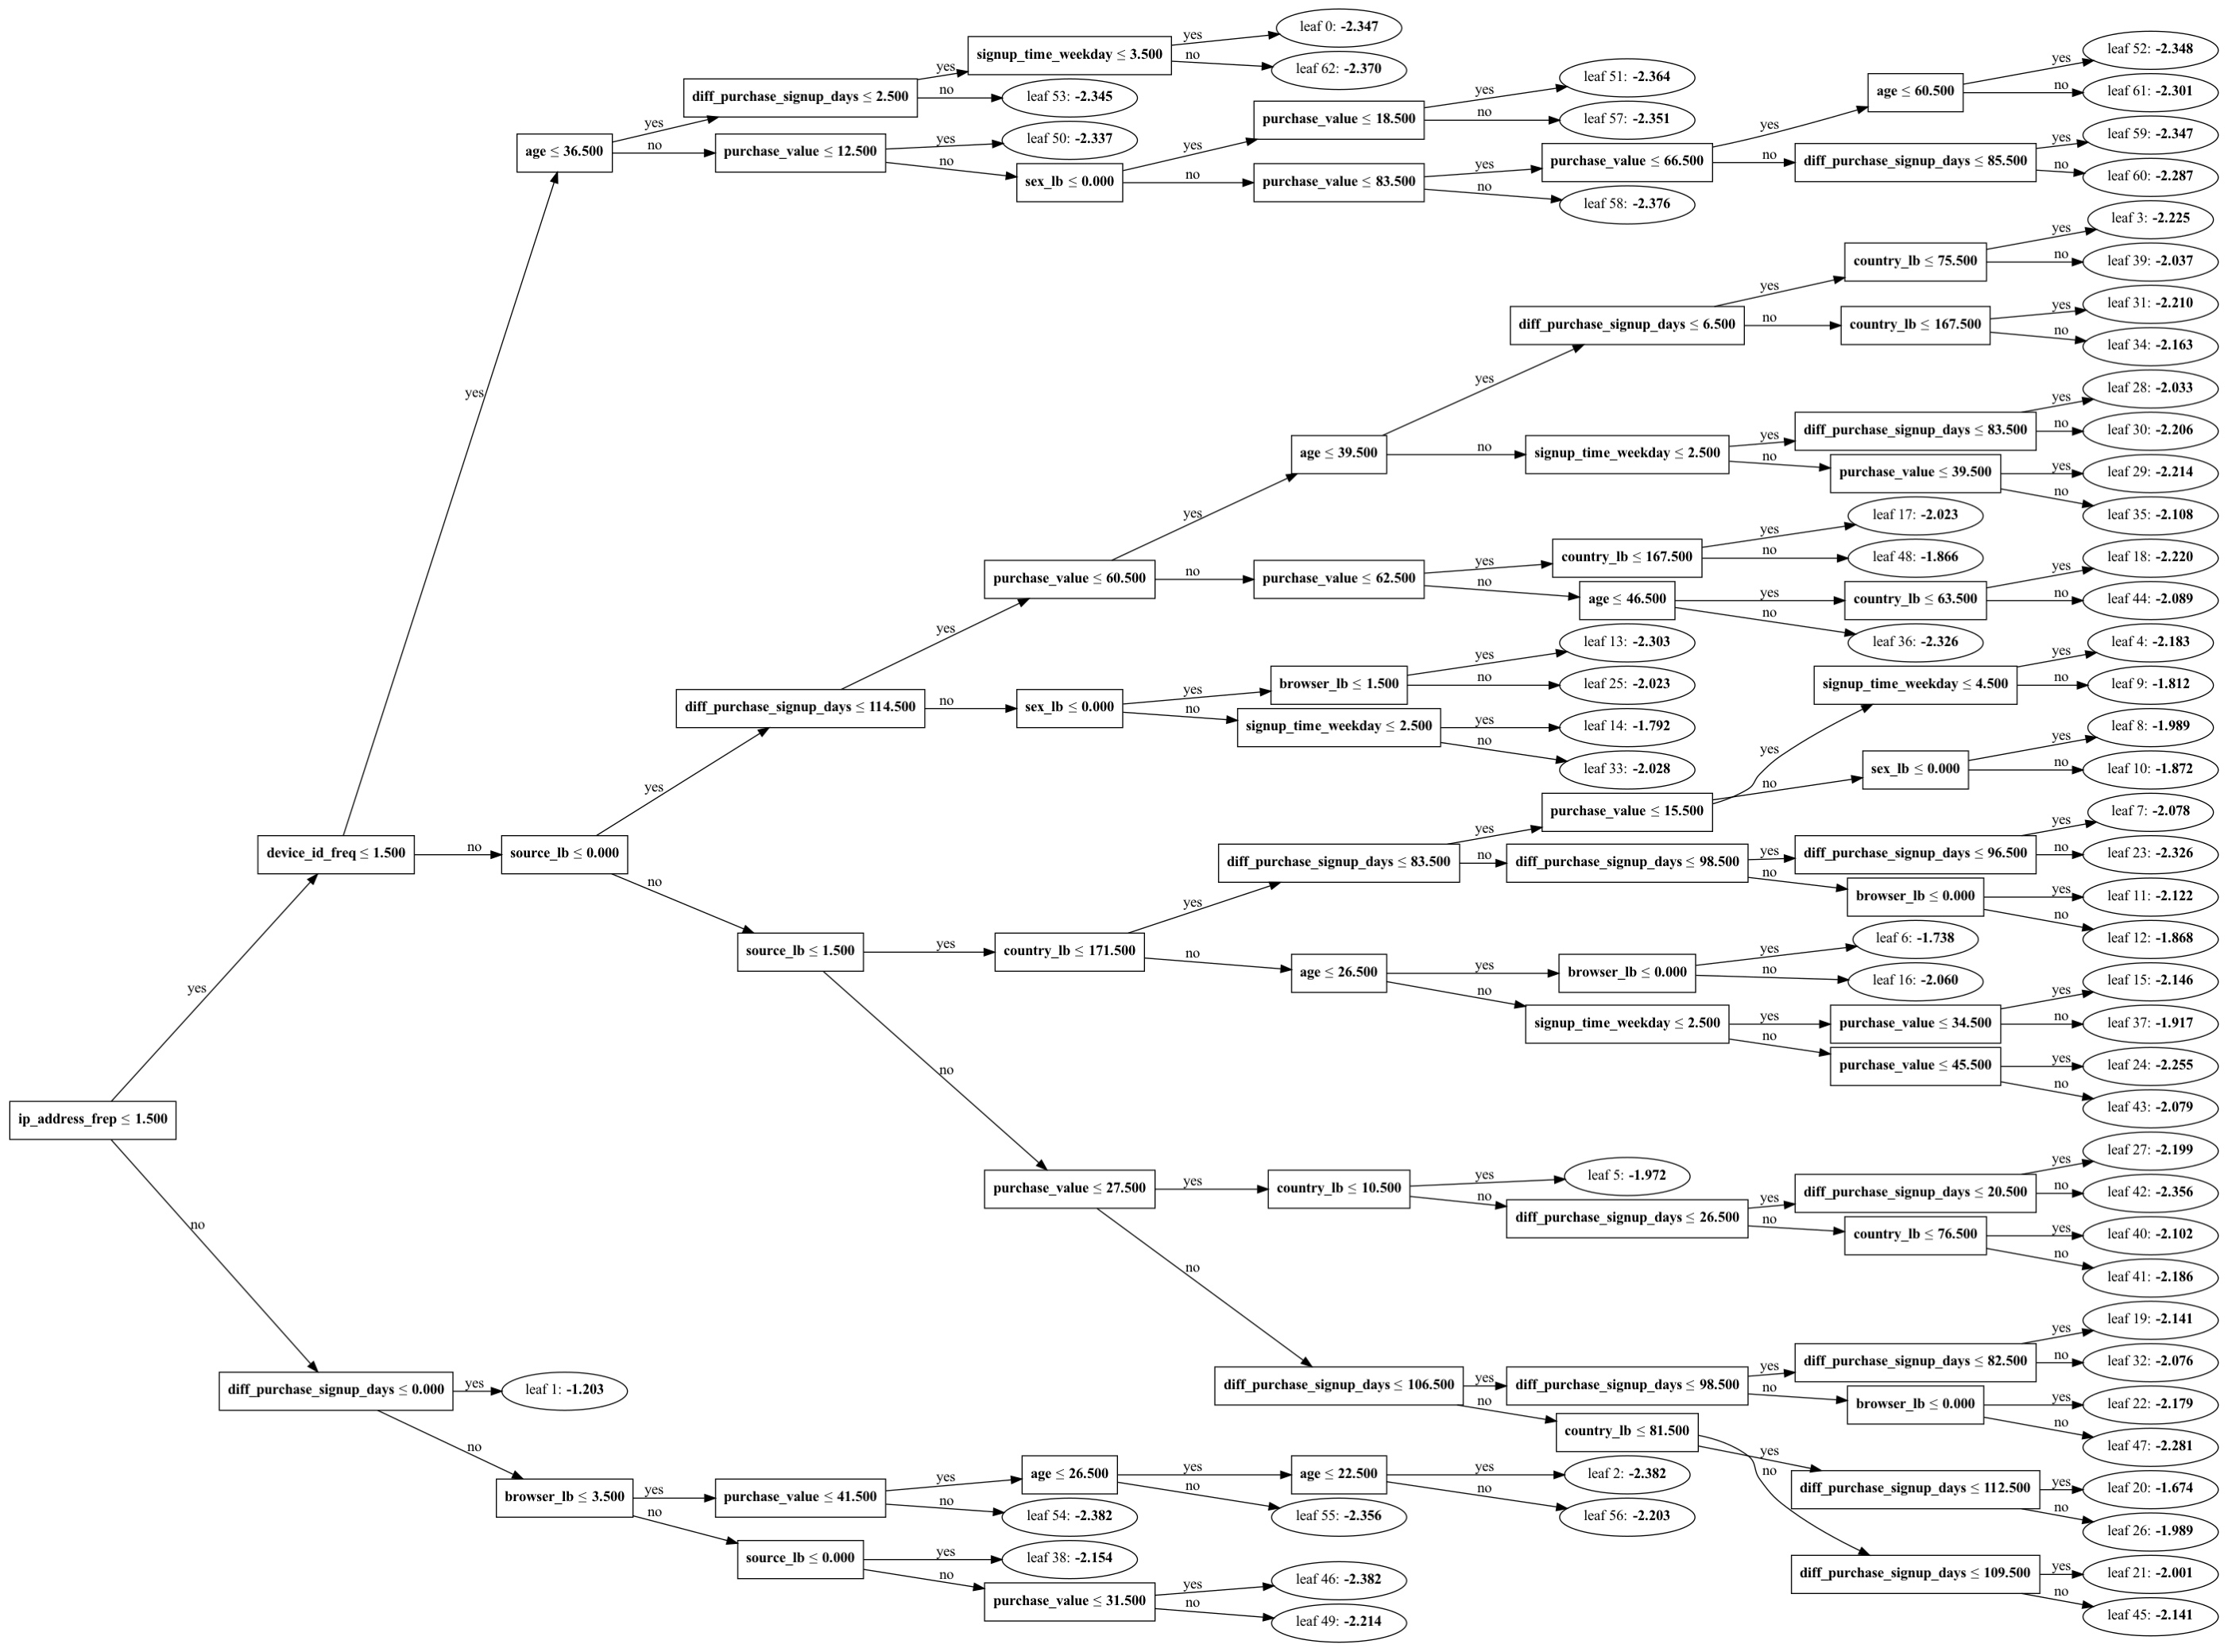

In [221]:
fig, ax = plt.subplots(figsize=(50, 40))
lgb.plot_tree(gbm_or, ax=ax, tree_index=0)

In [222]:
explainer = shap.Explainer(gbm_or, X_train)
shap_values = explainer(X_train)

100%|===================| 120813/120889 [04:11<00:00]        

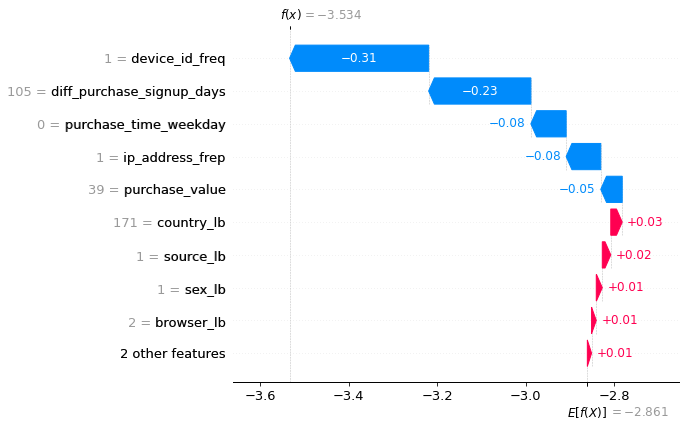

In [225]:
shap.plots.waterfall(shap_values[0])

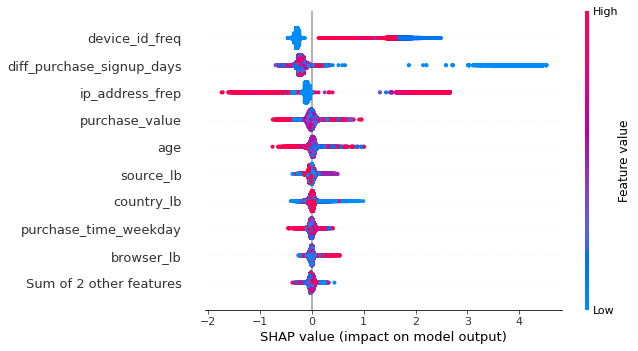

In [226]:
shap.plots.beeswarm(shap_values)

## Q4: Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

In [227]:
X_train.columns

Index(['purchase_value', 'age', 'signup_time_weekday', 'purchase_time_weekday',
       'diff_purchase_signup_days', 'device_id_freq', 'ip_address_frep',
       'source_lb', 'browser_lb', 'sex_lb', 'country_lb'],
      dtype='object')

### 假設模型performance不錯，且真的可以上線時...

- 回顧模型使用的變數
    - 註冊資訊、當下裝置,位置, 交易資訊 
    - 都是在交易完成前可以收集的資訊
- 交易當下
    - 透過模型給出機率值，將預測分等級 (ex: 0 ~ 0.25, 0.25 ~ 0.5, 0.5 ~ 0.75, 0.75 ~ 1)，可以分成，非詐騙用戶、低度潛在詐騙用戶、中度潛在詐騙用戶、高度潛在詐騙用戶，在訂單成立前進行不同難度的驗證方式 (輸入驗證碼，簡訊、信箱驗證)，若是高度詐騙則禁止當下交易（聯絡客服人員），或進一步ban掉帳號
- 用戶追蹤：如果是一個可以長期交易記錄的預測模型
    - 記錄每一次交易的預測結果，建立白、黑名單。
    - 內部帳號管理員處理方式優化：在其他用戶申訴時，優先觀察過往預測機率高的用戶，或定期對中高度潛在詐騙用戶進行身分驗證。
- 事後收集落點
    - 將中高度潛在詐騙用戶分群，找出特徵明顯的族群，協助警方人員調查

### 後續討論
- Monitoring: 需要監控哪些指標？模型準度如何即時監控？
- Continuous Training：何時重新訓練模型？特定事件觸發 or 週期性？
- Data / Model Drift: 有哪些方式可以觀察data & model drift？
